In [16]:
# import all the libraries we need
import os

import parsl
from parsl import python_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

# helpers
from group-utils import initialize_stager
from group-utils import plot_tiles

## Background

The first step in our workflow is to "stage" our data. Staging the data encompasses the following pre-processing tasks:

- simplify the polygons 
- set an input CRS if one is missing
- reproject the data when required
- add additional properties to each polygon, including: the centroid x and y
  coordinates, the area, a unique ID, and the name of the file that the
  polygon originated from
- break each input file into [standardized tiles](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html), and save them to disk.

Here is a diagram showing what the most important step, the last one, looks like.

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-staging/develop/docs/images/staging_tldr.png)

We will use some methods from the `pdgstaging` library to stage our tiles. The first step, is to initalize the `TileStager`. The `TileStager` is a class with methods `stage`, which works on a single vector file, and `stage_all` which stages all vector files in a directory.

### Initalize the stager

Fist we need to use the `initialize_stager` function to instantiate the `TileStager` object. The arguments to this function are `dir_input`, the directory of input vector files, and `dir_staged`, the directory of output vector files.

Input vector files are located **in `example-data`** TODO: find a home for these

In [17]:
# execute the initialize_stager function with the appropriate arguments
# save the result to a variable called iwp_stager
iwp_stager = initialize_stager("example-data", "staged-data")

Feel free to explore the `iwp_stager` object in any way you like.

Next let's use it to get a list of files to stage.

In [18]:
files_to_stage = iwp_stager.tiles.get_filenames_from_dir('input')

## Stage one file

Here is an example of how to run the stager on one file. We use the `stage` method on the `iwp_stager` object, with a path to a file as the argument to the method.

In [8]:
example_file = files_to_stage[0]
iwp_stager.stage(example_file)

Based on how long staging one file took, estimate how long that would take to stage all the input files that we have in this example, serially. How long would it take if we had 100 files? 1000?

In [9]:
print(f'{87 * len(files_to_stage)/60} minutes for examples, {round(87*100/60/60)} hours for 100 files, {round(87*1000/60/60)} hours for 1000 files')

50.75 minutes for examples, 2 hours for 100 files, 24 hours for 1000 files


For these example data, the amount of time it takes is not super high. But as the number of files gets bigger, things get out of hand quickly. Luckily for us, this problem is pleasingly parallel. The staging of each file is completely independent of the others. So, let's set this up as a `parsl` workflow using the skills we learned in Section 4. 

Just to get a sense of what happened, let's plot the result of our test staging effort using a `plot_tiles` helper we wrote for this activity.

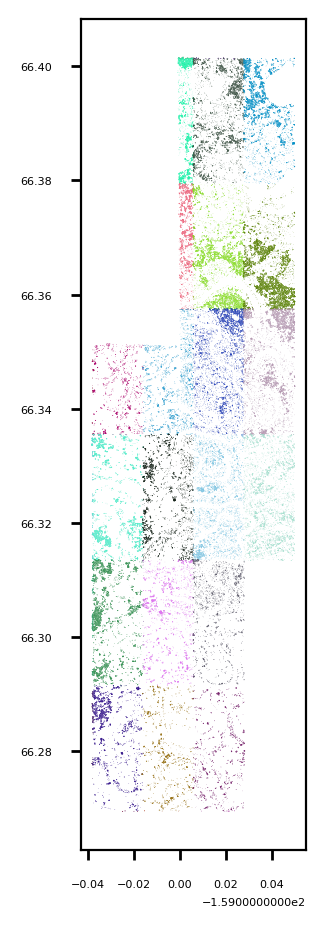

In [11]:
plot_tiles(iwp_stager)

Finally, let's remove the files we just created (including the staging summary csv file) to prepare to run this over all of the files.

In [12]:
os.system(f'rm -rf {iwp_stager.config.get("dir_staged")}')
os.system(f'rm {iwp_stager.config.get("filename_staging_summary")}')

0

### Staging in parallel

First set up the configuration for `parsl` using `config`. Make sure you pass the bash command you use to invoke your virtual environment to the `worker_init` argument as a string.

In [19]:
# htex_config = config(...)
activate_conda = 'source /home/sjclark/miniconda3/bin/activate scale_comp'
htex_local = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_local",
            worker_debug=False,
            cores_per_worker=1,
            max_workers=26,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=20,
                worker_init=activate_conda
            )
        )
    ],
)
parsl.clear()
parsl.load(htex_local)

Next, set up your Parsl app to run the `stage` method in parallel. You'll need to pass as arguments to the app function and the `TileStager` instance we created earlier.

In [20]:
# Make a Parsl app that uses the stage method
@python_app
def stage_file(path, stager):
    stager.stage(path)
    return path


Now, execute the app in parallel over all of the `files_to_stage`.

In [21]:
iwp_stager = initialize_stager("example-data", "staged-data")

app_futures = []
for path in files_to_stage:
    app_future = stage_file(path, iwp_stager)
    app_futures.append(app_future)

# By getting the `result()` of each app future, this block won't continue to 
# the print statement until all the files are staged.
done = [app_future.result() for app_future in app_futures]

Now we can check out the `plot_tiles` result again (which will only plot the first 90 of our tiled files)

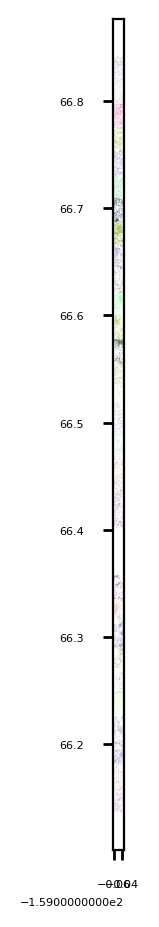

In [22]:
plot_tiles(iwp_stager)